<a href="https://colab.research.google.com/github/hepuliu/Masters_Thesis/blob/sandbox_lime/sandbox_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Master Thesis Simulation Sandbox
Flood Prevention Dam Sizing with Machine Learining Approaches - Hepu Liu

### Overall Project Simulation Steps
1. Process discharge data from Waldangelbach Station

2. Process precipitation data from Baiertal  Station

3. Build Prediction Model (Model A)

4. Process precipitation data from Stifterhof Station

5. Process precipitation data from Waibstadt Station (optional)

6. Process precipitation data from Stetten Station (optional

7. Fit data to Model A to predict discharge

### Variable Naming Conventions

- Weather Stations Naming: ('p' for precipitation, 'd' for discharge, 'a' to 'd' for different stations, 'r' for result)

  - da: Waldangelbach Station
  - pa: Baiertal Station
  - pb: Stifterhof Station
  - pc: Waibstadt Station
  - pd: Stetten Station
  - pr: combined/resulting precipitation
  - dr: predicted/resulting discharge

- Variable Naming Coventions: 
  - df: data frame
  - trs: training set
  - tes: testing set
  - fbp: FB Prophet
  - lstm: LSTM
  - ann: ANN 



## Importing Libraries

In [282]:
# importing libraries
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from google.colab import drive
drive.mount

<function google.colab.drive.mount>

## Importing Datasets

In [283]:
# import datafram for LSTM
df_lstm = pd.read_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/df_lstm.csv')
df_lstm

,ds,y,temp,rad,preci
0,2007-01-01 00:00:00,0.226,10.00,0.0,2.6
1,2007-01-01 01:00:00,0.248,10.58,0.0,0.8
2,2007-01-01 02:00:00,0.248,11.22,0.0,0.2
3,2007-01-01 03:00:00,0.320,11.42,0.0,0.6
4,2007-01-01 04:00:00,0.346,11.58,0.0,0.0
...,...,...,...,...,...
105148,2018-12-31 19:00:00,0.232,6.19,0.0,0.0
105149,2018-12-31 20:00:00,0.248,6.23,0.0,0.1
105150,2018-12-31 21:00:00,0.232,6.25,0.0,0.1
105151,2018-12-31 22:00:00,0.226,6.26,0.0,0.0


## Data Processing

In [284]:
# Data Processing for Multivariable LSTM - Testing (Smaller Dataset, row = 2500)
df_lstm = df_lstm.iloc[:4500, :]
df_lstm = df_lstm.set_index('ds')
df_lstm

,y,temp,rad,preci
ds,,,,
2007-01-01 00:00:00,0.226,10.00,0.0,2.6
2007-01-01 01:00:00,0.248,10.58,0.0,0.8
2007-01-01 02:00:00,0.248,11.22,0.0,0.2
2007-01-01 03:00:00,0.320,11.42,0.0,0.6
2007-01-01 04:00:00,0.346,11.58,0.0,0.0
...,...,...,...,...
2007-07-07 07:00:00,0.295,15.56,100.0,0.0
2007-07-07 08:00:00,0.295,16.78,100.0,0.0
2007-07-07 09:00:00,0.295,18.12,100.0,0.0


In [285]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

# assigne df values
values = df_lstm.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
df_lstm_reframed = series_to_supervised(scaled, 1, 1)
# drop columns not to be predicted
df_lstm_reframed.drop(df_lstm_reframed.columns[[5,6,7]], axis=1, inplace=True)
df_lstm_reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t)
1,0.009187,0.547736,0.0,0.158537,0.019293
2,0.019293,0.560735,0.0,0.048780,0.019293
3,0.019293,0.575078,0.0,0.012195,0.052366
4,0.052366,0.579561,0.0,0.036585,0.064309
5,0.064309,0.583147,0.0,0.000000,0.064309
...,...,...,...,...,...
4495,0.040882,0.633797,1.0,0.000000,0.040882
4496,0.040882,0.672344,1.0,0.000000,0.040882
4497,0.040882,0.699686,1.0,0.000000,0.040882
4498,0.040882,0.729718,1.0,0.000000,0.040882


In [286]:
# split into train and test sets
values = df_lstm_reframed.values
n = 4000
train = values[:n, :]
test = values[n:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4000, 1, 4) (4000,) (499, 1, 4) (499,)


## Prediction


Epoch 1/50
56/56 - 3s - loss: 0.0681 - val_loss: 0.0301 - 3s/epoch - 53ms/step
Epoch 2/50
56/56 - 0s - loss: 0.0626 - val_loss: 0.0275 - 203ms/epoch - 4ms/step
Epoch 3/50
56/56 - 0s - loss: 0.0573 - val_loss: 0.0250 - 203ms/epoch - 4ms/step
Epoch 4/50
56/56 - 0s - loss: 0.0519 - val_loss: 0.0230 - 153ms/epoch - 3ms/step
Epoch 5/50
56/56 - 0s - loss: 0.0467 - val_loss: 0.0212 - 196ms/epoch - 4ms/step
Epoch 6/50
56/56 - 0s - loss: 0.0408 - val_loss: 0.0194 - 196ms/epoch - 4ms/step
Epoch 7/50
56/56 - 0s - loss: 0.0336 - val_loss: 0.0196 - 171ms/epoch - 3ms/step
Epoch 8/50
56/56 - 0s - loss: 0.0246 - val_loss: 0.0247 - 187ms/epoch - 3ms/step
Epoch 9/50
56/56 - 0s - loss: 0.0162 - val_loss: 0.0126 - 204ms/epoch - 4ms/step
Epoch 10/50
56/56 - 0s - loss: 0.0097 - val_loss: 0.0117 - 226ms/epoch - 4ms/step
Epoch 11/50
56/56 - 0s - loss: 0.0085 - val_loss: 0.0108 - 178ms/epoch - 3ms/step
Epoch 12/50
56/56 - 0s - loss: 0.0076 - val_loss: 0.0102 - 188ms/epoch - 3ms/step
Epoch 13/50
56/56 - 0s - lo

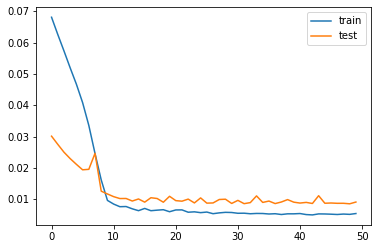

In [287]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [288]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.044


# Archive

In [289]:
# ## FBProphet

# # Multi Variant Prediction Model
# def predictor(df, reg1, reg2, reg3):
#   predictor = Prophet(interval_width=0.5)
#   predictor.add_regressor(reg1)
#   predictor.add_regressor(reg2)
#   predictor.add_regressor(reg3)
#   predictor.fit(df)
#   return predictor

# # Make Prediction Dataframe
# def prediction_df(predictor,df):
#   prediction_df = predictor.predict(df).loc[:,['ds','yhat']]
#   prediction_df['ds'] = prediction_df['ds'].apply(lambda x:x)
#   return prediction_df


# # Prediction for Discharge
# predictor = predictor(df_fbp,'temp','rad','preci')
# da_dr_fbp_predicted = prediction_df(predictor, df_fbp)
# # da_dr_fbp = results_df(df_fbp, da_dr_fbp_predicted)
# da_dr_fbp_predicted.to_csv('/content/drive/MyDrive/thesis/dataset/results/da_dr_fbp_predicted_2.csv', index=False)

In [290]:
# # Merge prediction df to original df
# da_dr_fbp_predicted = pd.read_csv('/content/drive/MyDrive/thesis/dataset/results/da_dr_fbp_predicted_2.csv')
# da_dr_fbp = da_dr_fbp_predicted.merge(df_fbp, on='ds', how='left')
# da_dr_fbp.to_csv('/content/drive/MyDrive/thesis/dataset/results/da_dr_fbp_2.csv', index=False)

In [291]:
# # Cleanup Discharge A DataFrame da_df
# da_df = pd.read_csv('/content/drive/MyDrive/thesis/dataset/Wiesloch_waldangelbach_hourly_20070101-20210501.csv')
# da_df = da_df.iloc[13:].reset_index(drop=True)
# da_df.columns = da_df.iloc[0]
# da_df = da_df.iloc[3:].reset_index(drop=True)
# da_df = da_df.iloc[:, 4:7] # precipitation unit [m3/s]
# da_df['Uhrzeit'] = da_df['Uhrzeit'].str.replace(' v', '')
# da_df['t'] = pd.to_datetime(da_df['Datum']+' '+da_df['Uhrzeit'], format=('%y-%m-%d %H:%M:%S'))
# da_df = da_df.iloc[:,2:]
# da_df.columns = ['discharge [m3/s]', 't']
# da_df = da_df[['t','discharge [m3/s]']]
# da_df.to_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/da_df.csv', index=False)

In [292]:
# # Cleanup Precipitation A DataFrame pa_df
# pa_df = pd.read_csv('/content/drive/MyDrive/thesis/dataset/Weather_station_Baiertal.csv')
# pa_df.columns = pa_df.iloc[0]
# pa_df = pa_df.iloc[1:].reset_index(drop=True)
# pa_df['t'] = pd.to_datetime(pa_df['date']+' '+pa_df['time'], format=('%y-%m-%d %H:%M'))
# pa_df = pa_df.iloc[:,2:]
# cols = list(pa_df.columns)
# cols = [cols[-1]] + cols[:-1]
# pa_df = pa_df[cols]
# pa_df.to_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/pa_df.csv', index=False)


In [293]:
# # Cleanup Precipitation B DataFrame pb_df
# pb_df = pd.read_csv('/content/drive/MyDrive/thesis/dataset/Weather_station_Stifterhof.csv')
# pb_df.columns = pb_df.iloc[0]
# pb_df = pb_df.iloc[1:].reset_index(drop=True)
# pb_df['t'] = pd.to_datetime(pb_df['date']+' '+pb_df['time'], format=('%y-%m-%d %H:%M'))
# pb_df = pb_df.iloc[:,2:]
# cols = list(pb_df.columns)
# cols = [cols[-1]] + cols[:-1]
# pb_df = pb_df[cols]
# pb_df.to_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/pb_df.csv', index=False)

In [294]:
# ## FBProphet

# # Single Variant Prediction Model
# def single_var_predictor(df):
#   predictor = Prophet(interval_width=0.95)
#   predictor.fit(df)
#   return predictor

# # Make Prediction Dataframe
# def prediction_df(predictor,df):
#   prediction_df = predictor.predict(df).loc[:,['ds','yhat']]
#   prediction_df['ds'] = prediction_df['ds'].apply(lambda x:x)
#   return prediction_df

# # Prediction for Discharge [15s for 2000 rows, 45s for 20000rows with GPU, 4m for all]
# discharge_predictor = single_var_predictor(da_df)
# da_dr = prediction_df(discharge_predictor, da_df)
# da_dr

In [295]:
# # Plot Line Graph 20000 row with GPU = 3mins
# def line_plot(df, title):
#   label_font = {'family':'serif', 'color':'black', 'size':'12'}
#   title_font = {'family':'serif', 'color':'black', 'size':'14'}
#   fig = plt.figure(figsize=(8,8))
#   plt.plot(df['ds'], df['yhat'])
#   plt.xlabel( 't', fontdict = label_font)
#   plt.ylabel( 'd', fontdict = label_font)
#   plt.title(title, fontdict = title_font)
   
# # line_plot(da_df, 'Discharge A')


In [296]:
# # Making Data Frame for FB Prophet

# df_fbp = da_df
# df_fbp = df_fbp.merge(pa_df, on = 't', how = 'left').dropna()
# df_fbp = df_fbp.drop(columns = ['wetness of leaves \n[%]'])
# df_fbp.columns = ['ds','y','temp','rad','preci']
# df_fbp
# df_fbp.to_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/df_fbp.csv', index=False)

In [297]:
# # import dataframe for fbp
# df_fbp = pd.read_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/df_fbp.csv')
# df_fbp

In [298]:
# # Making dataframe for LSTM
# df_lstm = pd.read_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/df_fbp.csv')
# df_lstm.to_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/df_lstm.csv', index=False)
# df_lstm

In [299]:
# # import precipitation dataset
# pa_df = pd.read_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/pa_df.csv', thousands='.', decimal=',')
# pa_df.head()

In [300]:
# # import discharge dataset
# da_df = pd.read_csv('/content/drive/MyDrive/thesis/dataset/cleaned_df/da_df.csv')
# da_df.head()